# Information Theory Project -- entroopy in recipes

## import libraries

In [104]:
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pyitlib import discrete_random_variable as drv
from sklearn.feature_selection import mutual_info_regression

%matplotlib inline

print("Libraries imported successfully.")

Libraries imported successfully.


## prepare dataset


In [105]:
recipes = pd.read_csv("RAW_recipes.csv")

In [106]:

print("Head of the dataset:")
print(recipes.head(), "\n")


Head of the dataset:
                                         name      id  minutes  \
0  arriba   baked winter squash mexican style  137739       55   
1            a bit different  breakfast pizza   31490       30   
2                   all in the kitchen  chili  112140      130   
3                          alouette  potatoes   59389       45   
4          amish  tomato ketchup  for canning   44061      190   

   contributor_id   submitted  \
0           47892  2005-09-16   
1           26278  2002-06-17   
2          196586  2005-02-25   
3           68585  2003-04-14   
4           41706  2002-10-25   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   
1  ['30-minutes-or-less', 'time-to-make', 'course...   
2  ['time-to-make', 'course', 'preparation', 'mai...   
3  ['60-minutes-or-less', 'time-to-make', 'course...   
4  ['weeknight', 'time-to-make', 'course', 'main-...   

                                    nutrition 

In [107]:
print("Dataset info:")
print(recipes.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB
None


In [108]:
# filtering only the columns we are interested in
recipes_filtered = recipes[['name', 'tags', 'minutes', 'n_ingredients', 'steps', 'ingredients']].copy()

# dropping rows with missing values in steps or ingredients
recipes_filtered.dropna(subset=['steps', 'ingredients'], inplace=True)

# converting steps from string to list, removing rows where list is empty
def not_empty_steps(steps_str):
    try:
        steps_list = eval(steps_str)
        return len(steps_list) > 0
    except:
        return False

recipes_filtered = recipes_filtered[recipes_filtered['steps'].apply(not_empty_steps)]

In [109]:
print("Dataset info after filtering:")
print(recipes_filtered.info())

Dataset info after filtering:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 231636 entries, 0 to 231636
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   name           231635 non-null  object
 1   tags           231636 non-null  object
 2   minutes        231636 non-null  int64 
 3   n_ingredients  231636 non-null  int64 
 4   steps          231636 non-null  object
 5   ingredients    231636 non-null  object
dtypes: int64(2), object(4)
memory usage: 12.4+ MB
None


In [110]:
# tokenizing the steps
def preprocess_and_tokenize(steps_str):
    steps_list = eval(steps_str)  # Convert string to list
    text = " ".join(steps_list).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    words = text.split()
    return words

recipes_filtered['tokenized_steps'] = recipes_filtered['steps'].apply(preprocess_and_tokenize)

print("Tokenization complete. Sample tokenized steps:")
print(recipes_filtered['tokenized_steps'].head())

Tokenization complete. Sample tokenized steps:
0    [make, a, choice, and, proceed, with, recipe, ...
1    [preheat, oven, to, degrees, f, press, dough, ...
2    [brown, ground, beef, in, large, pot, add, cho...
3    [place, potatoes, in, a, large, pot, of, light...
4    [mix, all, ingredients, boil, for, hours, or, ...
Name: tokenized_steps, dtype: object


## grouping recipes


In [111]:
# cuisine type
cuisines = [
    'italian', 'mexican', 'indian', 'chinese', 'french',
    'japanese', 'american', 'greek', 'thai', 'polish', 'english'
]

def extract_cuisine(tags_str):
    try:
        tags_list = eval(tags_str)
    except:
        return 'other'
    for c in cuisines:
        if c in tags_list:
            return c
    return 'other'

recipes_filtered['cuisine'] = recipes_filtered['tags'].apply(extract_cuisine)

cuisines_summary = recipes_filtered['cuisine'].value_counts()
print("Cuisine types summary:\n", cuisines_summary, "\n")

Cuisine types summary:
 other       175708
american     29010
italian       7410
mexican       6677
indian        2706
greek         2213
french        2201
chinese       1995
english       1416
thai          1156
japanese       795
polish         349
Name: cuisine, dtype: int64 



In [112]:
#recipe length
def calculate_recipe_length(steps_str):
    steps_list = eval(steps_str)  # string to list
    total_words = sum(len(step.split()) for step in steps_list)
    return total_words

recipes_filtered['recipe_length'] = recipes_filtered['steps'].apply(calculate_recipe_length)

length_summary = recipes_filtered['recipe_length'].describe()
print("Recipe Length Summary:\n", length_summary, "\n")

q1_33, q2_67 = recipes_filtered['recipe_length'].quantile([0.33, 0.67])

def categorize_length(length):
    if length <= q1_33:
        return 'short'
    elif length <= q2_67:
        return 'medium'
    else:
        return 'long'
    
recipes_filtered['length_category'] = recipes_filtered['recipe_length'].apply(categorize_length)
print("Distribution of length categories:\n", recipes_filtered['length_category'].value_counts(), "\n")

Recipe Length Summary:
 count    231636.000000
mean        102.081900
std          73.948436
min           1.000000
25%          54.000000
50%          86.000000
75%         130.000000
max        2246.000000
Name: recipe_length, dtype: float64 

Distribution of length categories:
 medium    77764
short     77475
long      76397
Name: length_category, dtype: int64 



In [113]:
# preparation time
time_summary = recipes_filtered['minutes'].describe()
print("Preparation Time Summary:\n", time_summary, "\n")

time_q1_33, time_q2_67 = recipes_filtered['minutes'].quantile([0.33, 0.67])

def categorize_time(minutes):
    if minutes <= time_q1_33:
        return 'short'
    elif minutes <= time_q2_67:
        return 'medium'
    else:
        return 'long'

recipes_filtered['time_category'] = recipes_filtered['minutes'].apply(categorize_time)
print("Distribution of time categories :\n", recipes_filtered['time_category'].value_counts(), "\n")

Preparation Time Summary:
 count    2.316360e+05
mean     9.398586e+03
std      4.461973e+06
min      0.000000e+00
25%      2.000000e+01
50%      4.000000e+01
75%      6.500000e+01
max      2.147484e+09
Name: minutes, dtype: float64 

Distribution of time categories :
 medium    80392
short     78159
long      73085
Name: time_category, dtype: int64 



In [114]:
# number of ingredients
ingredient_summary = recipes_filtered['n_ingredients'].describe()
print("Number of Ingredients Summary:\n", ingredient_summary, "\n")

quantiles_ingredients = recipes_filtered['n_ingredients'].quantile([0.2, 0.4, 0.6, 0.8])
q2, q4, q6, q8 = quantiles_ingredients[0.2], quantiles_ingredients[0.4], quantiles_ingredients[0.6], quantiles_ingredients[0.8]

def categorize_ingredients(n):
    if n <= q2:
        return 'very few'
    elif n <= q4:
        return 'few'
    elif n <= q6:
        return 'moderate'
    elif n <= q8:
        return 'many'
    else:
        return 'very many'
    
recipes_filtered['ingredient_category'] = recipes_filtered['n_ingredients'].apply(categorize_ingredients)
print("Distribution of ingredient categories:\n", recipes_filtered['ingredient_category'].value_counts())

Number of Ingredients Summary:
 count    231636.000000
mean          9.051141
std           3.734799
min           1.000000
25%           6.000000
50%           9.000000
75%          11.000000
max          43.000000
Name: n_ingredients, dtype: float64 

Distribution of ingredient categories:
 very few     61659
few          50131
moderate     47029
very many    38559
many         34258
Name: ingredient_category, dtype: int64


In [115]:
# diet 
def find_diet_tags(tags_str):
    tags_list = eval(tags_str)
    if 'meat' in tags_list:
        return 'meat'
    elif 'vegetarian' in tags_list:
        return 'vegetarian'
    elif 'vegan' in tags_list:
        return 'vegan'
    return 'other'

recipes_filtered['diet_tags'] = recipes_filtered['tags'].apply(find_diet_tags)
print("Distribution of diet categories:\n", recipes_filtered['diet_tags'].value_counts())

Distribution of diet categories:
 other         139960
meat           56042
vegetarian     35634
Name: diet_tags, dtype: int64


In [116]:
groups = ['cuisine', 'length_category', 'time_category', 'ingredient_category', 'diet_tags']

## helper functions

In [117]:
# shannon entropy (unigrams)
def calculate_entropy(words):
    word_counts = Counter(words)
    total_words = len(words)
    if total_words == 0:
        return 0.0
    probabilities = [count / total_words for count in word_counts.values()]
    entropy = -sum(p * np.log2(p) for p in probabilities)
    return entropy

recipes_filtered['entropy'] = recipes_filtered['tokenized_steps'].apply(calculate_entropy)

print("Basic entropy stats on the whole dataset:")
print(recipes_filtered['entropy'].describe())

Basic entropy stats on the whole dataset:
count    231636.000000
mean          5.451791
std           0.704029
min          -0.000000
25%           5.092987
50%           5.539623
75%           5.918865
max           7.999994
Name: entropy, dtype: float64


In [118]:
# conditional entropy (bigrams)
def calculate_conditional_entropy(words):
    bigrams = [(words[i], words[i+1]) for i in range(len(words) - 1)]
    if len(bigrams) == 0:
        return 0.0
    
    bigram_counts = Counter(bigrams)
    unigram_counts = Counter(words)
    conditional_entropy_value = 0.0
    total_bigrams = sum(bigram_counts.values())
    
    for (w1, w2), count in bigram_counts.items():
        p_w1w2 = count / total_bigrams
        p_w1 = unigram_counts[w1] / len(words)
        if p_w1 > 0:
            p_cond = p_w1w2 / p_w1
            if p_cond > 0:
                conditional_entropy_value += p_w1w2 * np.log2(p_cond)
    
    conditional_entropy_value = -conditional_entropy_value
    return conditional_entropy_value

recipes_filtered['conditional_entropy'] = recipes_filtered['tokenized_steps'].apply(calculate_conditional_entropy)
print("Basic conditional entropy stats on the whole dataset:")
print(recipes_filtered['conditional_entropy'].describe())

Basic conditional entropy stats on the whole dataset:
count    231636.000000
mean          0.612983
std           0.346685
min          -1.000000
25%           0.379619
50%           0.603108
75%           0.839824
max           2.567500
Name: conditional_entropy, dtype: float64


In [119]:
def print_entropy(df, col_name):
    avg_entropy = df.groupby(col_name)['entropy'].mean().sort_values()
    avg_cond_entropy = df.groupby(col_name)['conditional_entropy'].mean().sort_values()
    
    print(f"\nAverage Entropy by {col_name.title()}")
    print(avg_entropy)
    print(f"\nAverage Conditional Entropy by {col_name.title()}")
    print(avg_cond_entropy)
    
    return avg_entropy, avg_cond_entropy

In [120]:
def plot_entropy(col_name, avg_entropy, avg_cond_entropy):
    plt.figure(figsize=(8, 4))
    avg_entropy.plot(kind='bar', color='skyblue')
    plt.title(f'Average Entropy by {col_name.title()}')
    plt.xlabel(col_name.title())
    plt.ylabel('Entropy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 4))
    avg_cond_entropy.plot(kind='bar', color='orange')
    plt.title(f'Average Conditional Entropy by {col_name.title()}')
    plt.xlabel(col_name.title())
    plt.ylabel('Conditional Entropy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
        

In [121]:
def calculate_ngram_entropy(words, n):
    if len(words) < n:
        return 0.0

    ngrams = []
    for i in range(len(words) - n + 1):
        ngram_tuple = tuple(words[i:i+n])
        ngrams.append(ngram_tuple)

    from collections import Counter
    import numpy as np

    ngram_counts = Counter(ngrams)
    total_ngrams = len(ngrams)

    entropy = 0.0
    for count in ngram_counts.values():
        p = count / total_ngrams
        entropy -= p * np.log2(p)
    return entropy

In [122]:
def analyze_and_plot_ngram_entropy(df, group_col, ngram):
    avg_ngram = df.groupby(group_col)[ngram].mean().sort_values()
    
    print(f'\nAverage {ngram} by {group_col.title()}')
    print(avg_ngram)
    
    # plotting average n-gram entropy
    plt.figure(figsize=(8, 4))
    avg_ngram.plot(kind='bar', color='green')
    plt.title(f'Average {ngram} by {group_col.title()}')
    plt.xlabel(group_col.title())
    plt.ylabel(f'{ngram}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [123]:
def mutual_info(df, col1, col2):
    temp_df = df[[col1, col2]].dropna().copy()

    # converting columns to strings to unify types
    temp_df[col1] = temp_df[col1].astype(str)
    temp_df[col2] = temp_df[col2].astype(str)

    # converting to category -> integer codes
    temp_df[col1] = temp_df[col1].astype('category')
    temp_df[col2] = temp_df[col2].astype('category')
    x_cat = temp_df[col1].cat.codes.astype(int).values  # .values => np array
    y_cat = temp_df[col2].cat.codes.astype(int).values

    # checking for negative codes
    neg_mask = (x_cat < 0) | (y_cat < 0)
    if neg_mask.any():
        print(f"[DEBUG] Dropping {neg_mask.sum()} rows with negative codes in {col1} or {col2}.")
        x_cat = x_cat[~neg_mask]
        y_cat = y_cat[~neg_mask]

    # if no data left, return 0
    if len(x_cat) == 0:
        print(f"[WARNING] No valid rows remain for {col1} vs {col2} — returning 0.")
        return 0.0

    # calling information_mutual with explicit alphabets
    return drv.information_mutual(
        X=x_cat, Y=y_cat,
        cartesian_product=False,
        Alphabet_X=None, # let it infer from x_cat
        Alphabet_Y=None, # let it infer from y_cat
        estimator='ML', # default
        base=2 # MI in bits
    )

In [124]:
def run_analyses_solo(df, col_name):
    avg_entropy, avg_cond_entropy = print_entropy(df, col_name)
    plot_entropy(col_name, avg_entropy, avg_cond_entropy)
    for n_gram_size in [3, 4, 5]:
        ngram = f"{n_gram_size}gram_entropy"
        df[ngram] = df['tokenized_steps'].apply(lambda words: calculate_ngram_entropy(words, n=n_gram_size))
        analyze_and_plot_ngram_entropy(df, col_name, ngram)

In [125]:
def run_analyses_pair(df, col1, col2):
    mi = mutual_info(df, col1, col2)
    print(f"Mutual Information between {col1} and {col2}: {mi:.4f}")

In [126]:
# zipf's law
def calculate_word_frequencies(tokenized_col):
    all_words = []
    for tokens in tokenized_col:
        all_words.extend(tokens)
    
    word_counts = Counter(all_words)
    ranked_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    ranks = np.arange(1, len(ranked_words) + 1)
    frequencies = np.array([freq for _, freq in ranked_words])
    return ranks, frequencies

In [127]:
def power_law(rank, alpha, C):
    return C * rank ** (-alpha)

In [128]:
def fit_power_law(ranks, frequencies):
    params, _ = curve_fit(power_law, ranks, frequencies, maxfev=10000)
    alpha, C = params
    
    predicted = power_law(ranks, alpha, C)
    ss_res = np.sum((frequencies - predicted) ** 2)
    ss_tot = np.sum((frequencies - np.mean(frequencies)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    return alpha, C, r_squared

In [129]:
def zipf_analysis(df, group_col):
    grouped = df.groupby(group_col)
    
    plt.figure(figsize=(10, 6))
    for label, group_df in grouped:
        ranks, frequencies = calculate_word_frequencies(group_df['tokenized_steps'])
        if len(ranks) > 0:
            plt.loglog(ranks, frequencies, label=label, alpha=0.7)
    plt.title(f"Zipf's Law ({group_col.title()})")
    plt.xlabel("Log(Rank)")
    plt.ylabel("Log(Frequency)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    print(f"\nZipf's Law Fit Results (alpha, R^2) by {group_col.title()}")
    for label, group_df in grouped:
        ranks, frequencies = calculate_word_frequencies(group_df['tokenized_steps'])
        if len(ranks) > 5:
            alpha, C, r2 = fit_power_law(ranks, frequencies)
            print(f"{label:20s} -> alpha = {alpha:.2f}, R^2 = {r2:.2f}")
        else:
            print(f"{label:20s} -> Not enough words to fit a power law.")

## analyses and plots


Average Entropy by Cuisine
cuisine
other       5.425782
japanese    5.453230
american    5.460493
mexican     5.530682
thai        5.569855
greek       5.571577
indian      5.582138
chinese     5.607801
polish      5.668986
italian     5.677138
english     5.707811
french      5.731660
Name: entropy, dtype: float64

Average Conditional Entropy by Cuisine
cuisine
other       0.596255
american    0.602172
mexican     0.642093
japanese    0.676789
thai        0.708442
greek       0.710462
polish      0.726241
italian     0.764622
indian      0.766890
chinese     0.773229
english     0.826957
french      0.830789
Name: conditional_entropy, dtype: float64


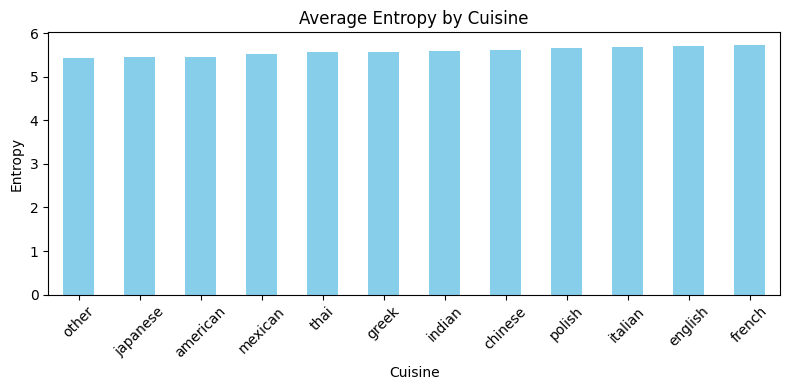

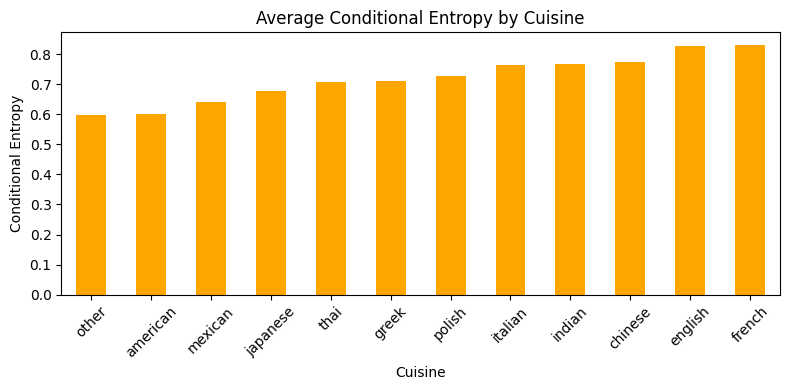


Average 3gram_entropy by Cuisine
cuisine
other       6.063025
american    6.105760
japanese    6.188673
mexican     6.222261
thai        6.344106
greek       6.345649
indian      6.430703
polish      6.454200
chinese     6.464486
italian     6.519914
english     6.618408
french      6.655038
Name: 3gram_entropy, dtype: float64


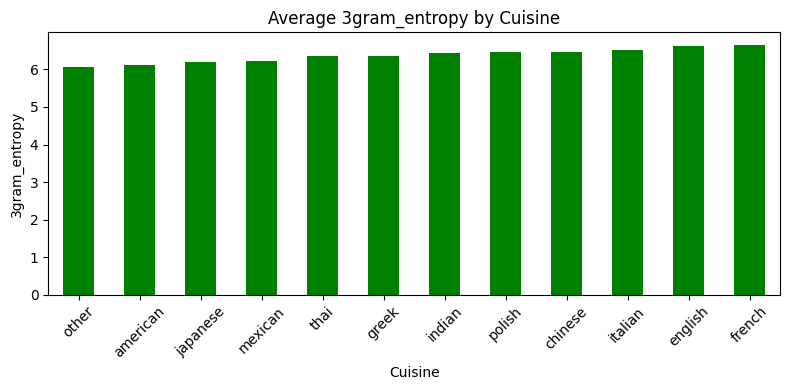


Average 4gram_entropy by Cuisine
cuisine
other       6.047431
american    6.091789
japanese    6.174334
mexican     6.211541
greek       6.338894
thai        6.340512
indian      6.429789
polish      6.448332
chinese     6.466921
italian     6.520556
english     6.617552
french      6.657460
Name: 4gram_entropy, dtype: float64


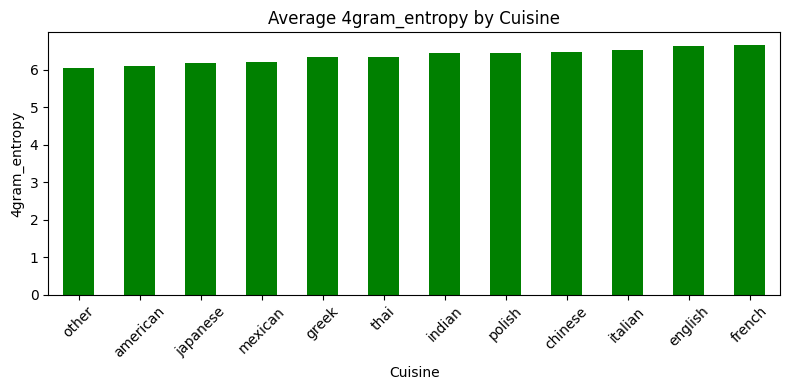


Average 5gram_entropy by Cuisine
cuisine
other       6.019809
american    6.065720
japanese    6.146377
mexican     6.188124
greek       6.317345
thai        6.322671
indian      6.412079
polish      6.429406
chinese     6.451689
italian     6.505911
english     6.602317
french      6.643820
Name: 5gram_entropy, dtype: float64


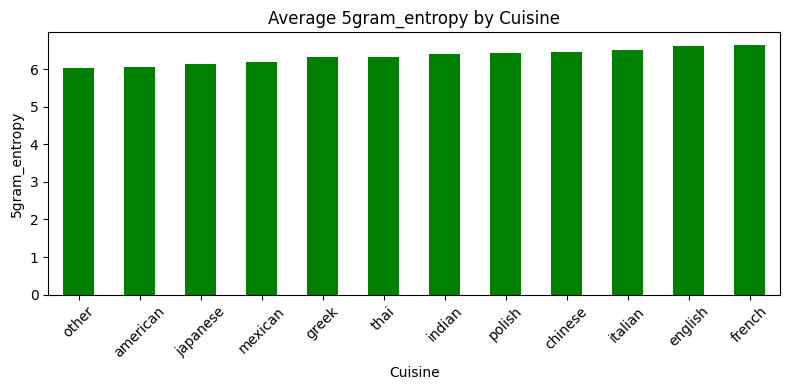


Average Entropy by Length_Category
length_category
short     4.711666
medium    5.550371
long      6.102016
Name: entropy, dtype: float64

Average Conditional Entropy by Length_Category
length_category
short     0.280603
medium    0.606489
long      0.956663
Name: conditional_entropy, dtype: float64


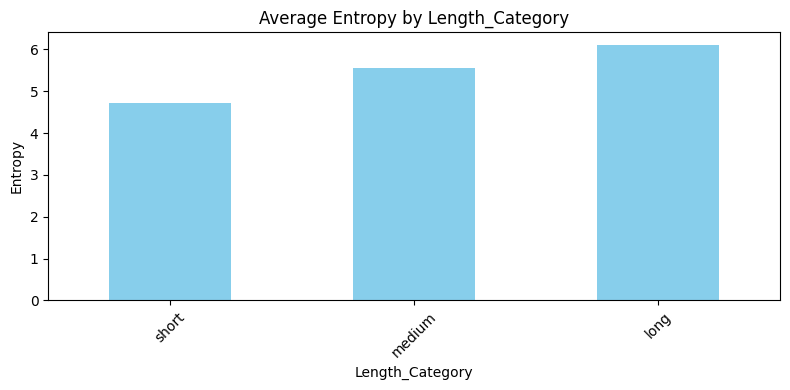

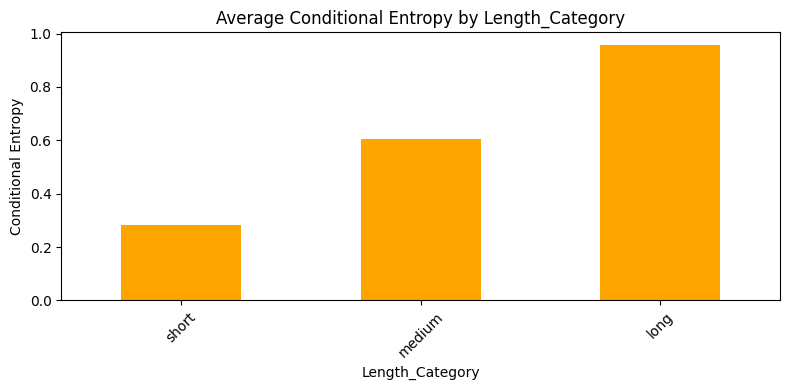


Average 3gram_entropy by Length_Category
length_category
short     4.961246
medium    6.202137
long      7.179600
Name: 3gram_entropy, dtype: float64


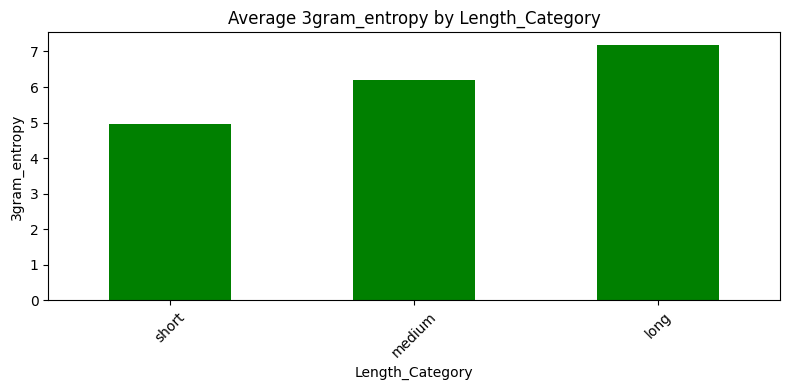


Average 4gram_entropy by Length_Category
length_category
short     4.908155
medium    6.196344
long      7.196952
Name: 4gram_entropy, dtype: float64


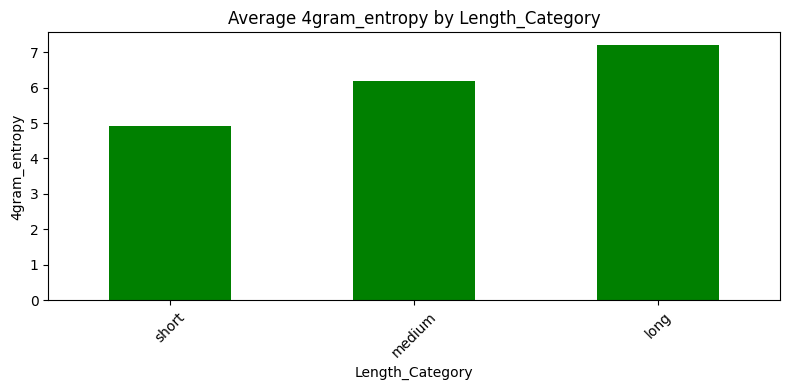


Average 5gram_entropy by Length_Category
length_category
short     4.847515
medium    6.180177
long      7.195035
Name: 5gram_entropy, dtype: float64


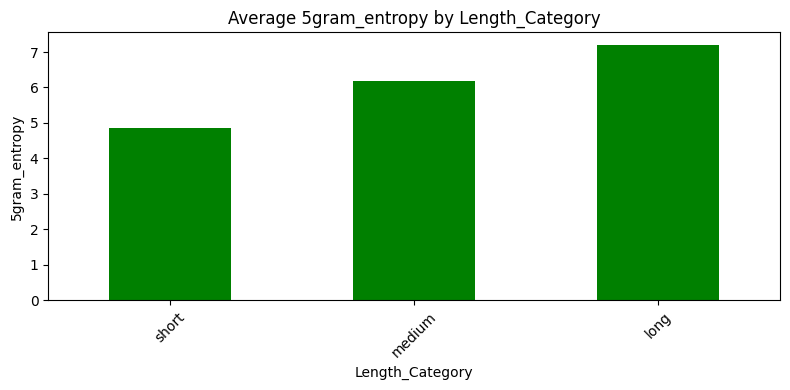


Average Entropy by Time_Category
time_category
short     5.065607
medium    5.606004
long      5.695155
Name: entropy, dtype: float64

Average Conditional Entropy by Time_Category
time_category
short     0.456043
medium    0.666196
long      0.722285
Name: conditional_entropy, dtype: float64


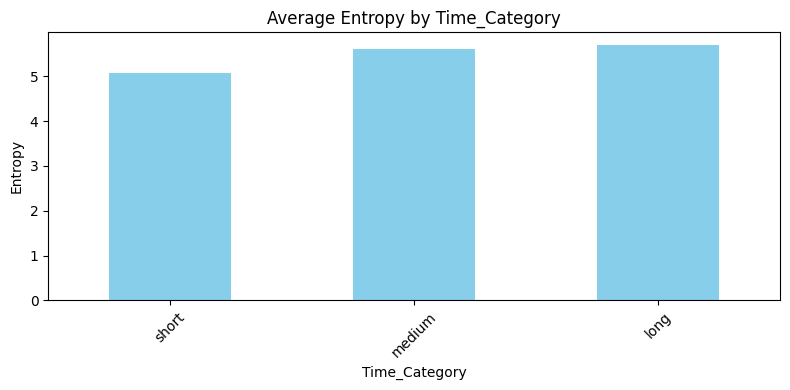

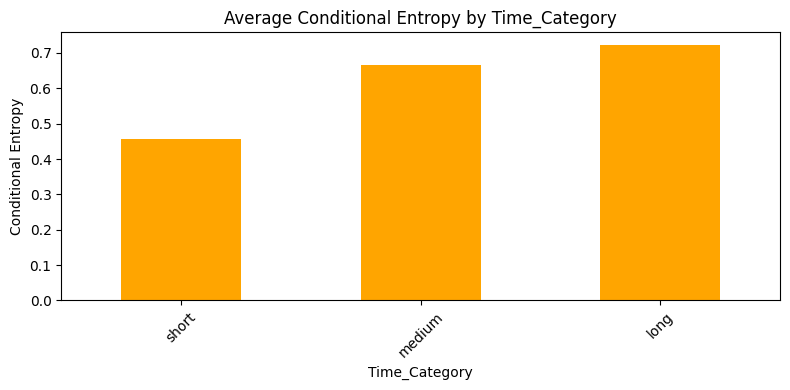


Average 3gram_entropy by Time_Category
time_category
short     5.527426
medium    6.329994
long      6.489381
Name: 3gram_entropy, dtype: float64


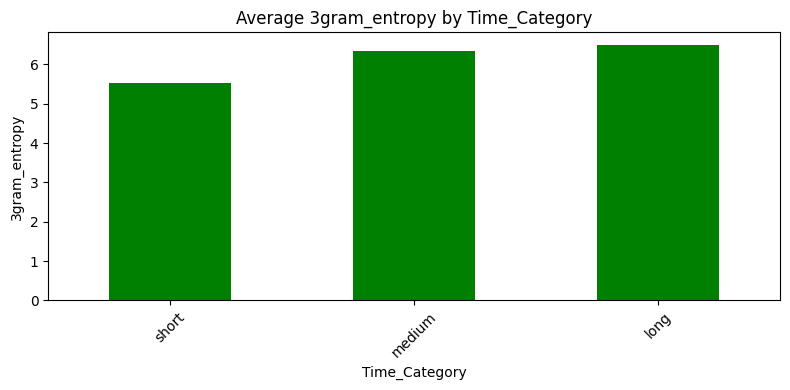


Average 4gram_entropy by Time_Category
time_category
short     5.491969
medium    6.325270
long      6.488191
Name: 4gram_entropy, dtype: float64


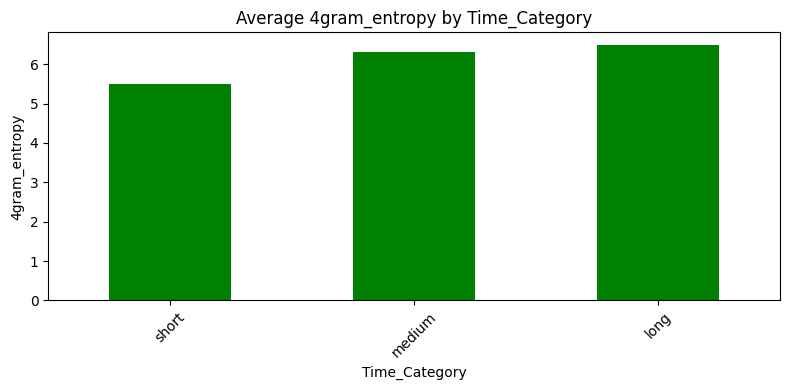


Average 5gram_entropy by Time_Category
time_category
short     5.446015
medium    6.308163
long      6.472666
Name: 5gram_entropy, dtype: float64


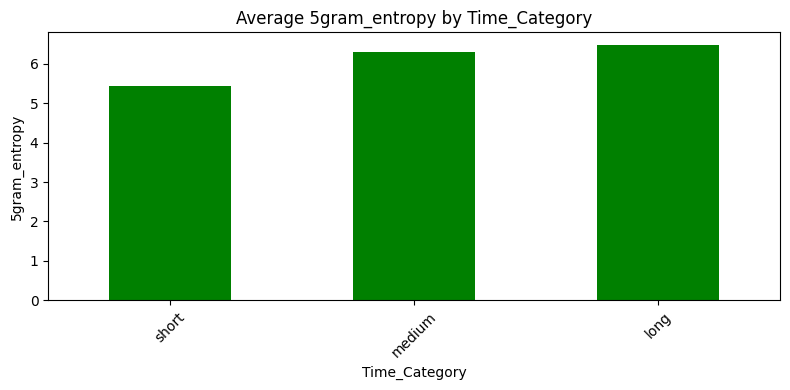


Average Entropy by Ingredient_Category
ingredient_category
very few     5.061944
few          5.375043
moderate     5.535989
many         5.669748
very many    5.878632
Name: entropy, dtype: float64

Average Conditional Entropy by Ingredient_Category
ingredient_category
very few     0.446062
few          0.562041
moderate     0.636718
many         0.706440
very many    0.834153
Name: conditional_entropy, dtype: float64


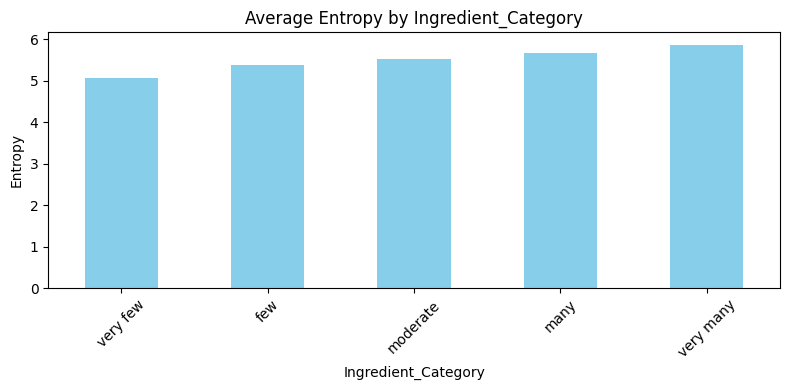

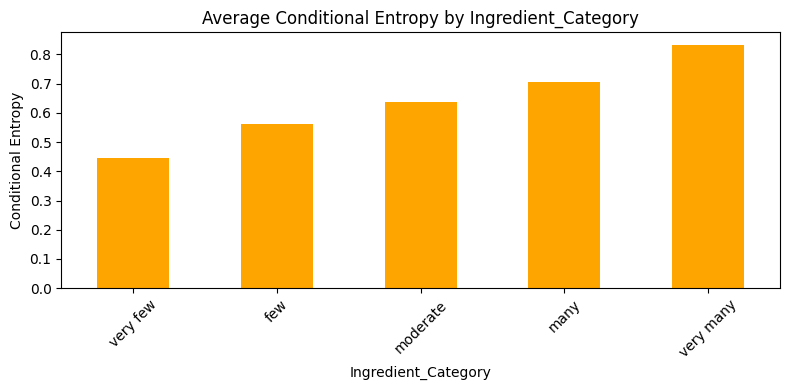


Average 3gram_entropy by Ingredient_Category
ingredient_category
very few     5.514010
few          5.971096
moderate     6.223230
many         6.441870
very many    6.807546
Name: 3gram_entropy, dtype: float64


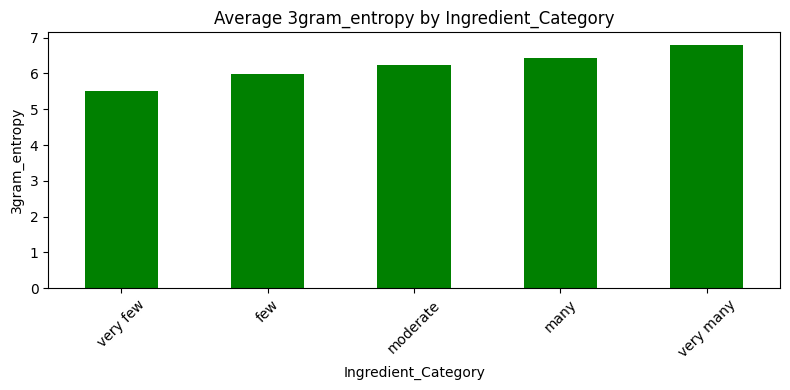


Average 4gram_entropy by Ingredient_Category
ingredient_category
very few     5.477908
few          5.953855
moderate     6.214315
many         6.439840
very many    6.816391
Name: 4gram_entropy, dtype: float64


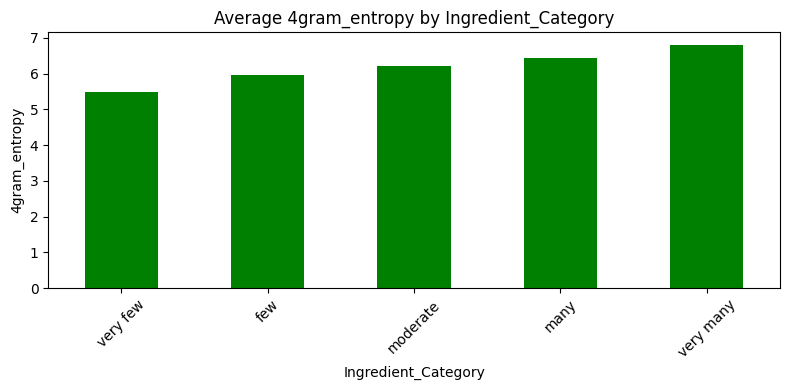


Average 5gram_entropy by Ingredient_Category
ingredient_category
very few     5.431398
few          5.925890
moderate     6.193459
many         6.424403
very many    6.808032
Name: 5gram_entropy, dtype: float64


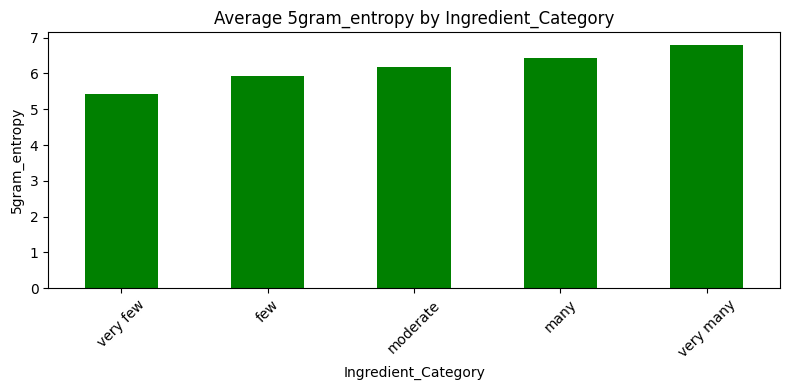


Average Entropy by Diet_Tags
diet_tags
vegetarian    5.408750
other         5.409168
meat          5.585606
Name: entropy, dtype: float64

Average Conditional Entropy by Diet_Tags
diet_tags
other         0.582526
vegetarian    0.610124
meat          0.690863
Name: conditional_entropy, dtype: float64


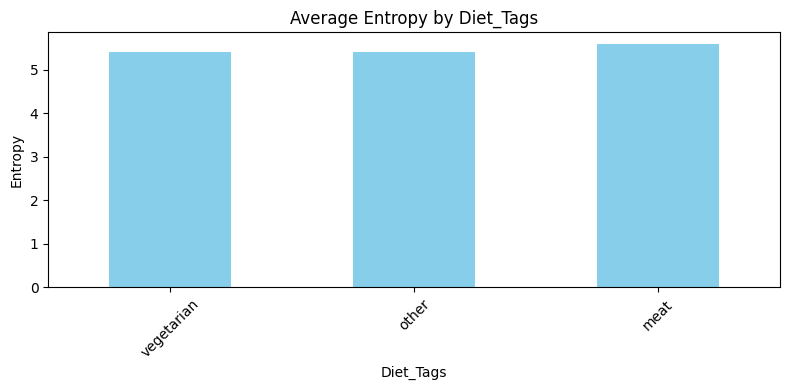

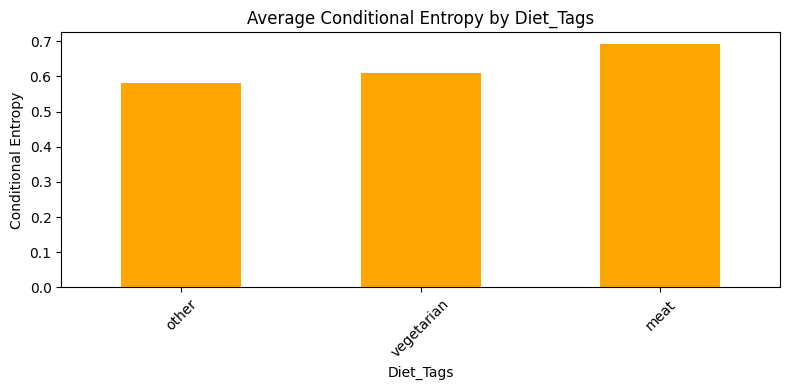


Average 3gram_entropy by Diet_Tags
diet_tags
other         6.028680
vegetarian    6.060484
meat          6.342423
Name: 3gram_entropy, dtype: float64


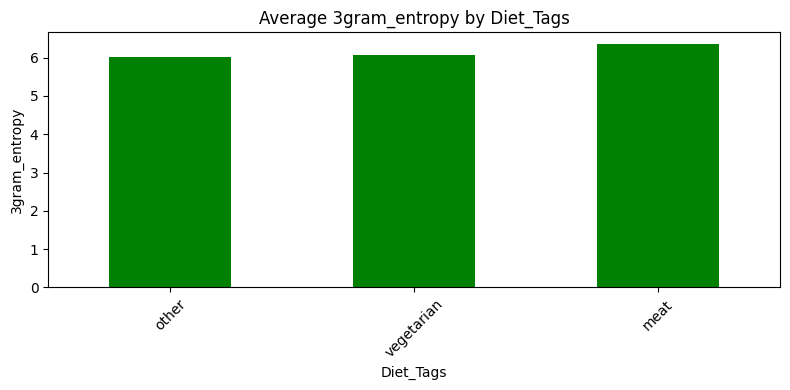


Average 4gram_entropy by Diet_Tags
diet_tags
other         6.010980
vegetarian    6.044144
meat          6.339238
Name: 4gram_entropy, dtype: float64


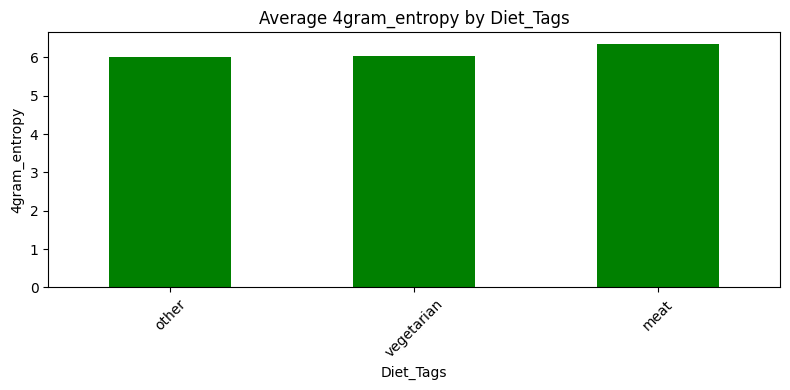


Average 5gram_entropy by Diet_Tags
diet_tags
other         5.981589
vegetarian    6.015479
meat          6.321990
Name: 5gram_entropy, dtype: float64


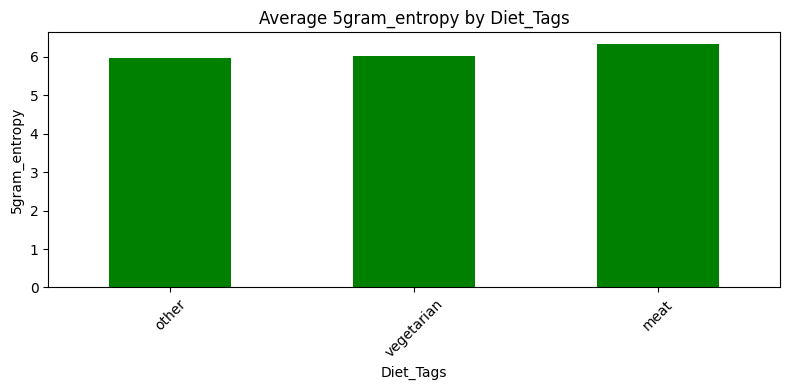

In [130]:
for col in groups:
    run_analyses_solo(recipes_filtered, col)

In [131]:
for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        run_analyses_pair(recipes_filtered, groups[i], groups[j])

Mutual Information between cuisine and length_category: 0.0093
Mutual Information between cuisine and time_category: 0.0032
Mutual Information between cuisine and ingredient_category: 0.0118
Mutual Information between cuisine and diet_tags: 0.0205
Mutual Information between length_category and time_category: 0.1008
Mutual Information between length_category and ingredient_category: 0.1352
Mutual Information between length_category and diet_tags: 0.0096
Mutual Information between time_category and ingredient_category: 0.0928
Mutual Information between time_category and diet_tags: 0.0312
Mutual Information between ingredient_category and diet_tags: 0.0231


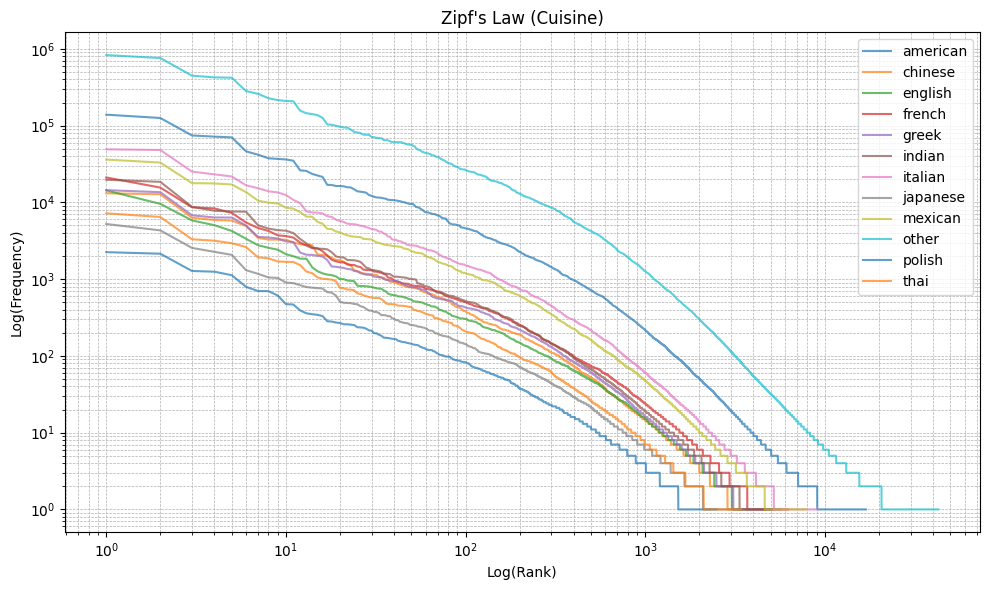


Zipf's Law Fit Results (alpha, R^2) by Cuisine


C:\Users\Kvmilos\AppData\Local\Temp\ipykernel_24668\523992455.py:2: RuntimeWarning: overflow encountered in power
  return C * rank ** (-alpha)
C:\Users\Kvmilos\AppData\Local\Temp\ipykernel_24668\523992455.py:2: RuntimeWarning: overflow encountered in multiply
  return C * rank ** (-alpha)


american             -> alpha = 0.78, R^2 = 0.95
chinese              -> alpha = 0.79, R^2 = 0.94
english              -> alpha = 0.87, R^2 = 0.99
french               -> alpha = 0.84, R^2 = 0.98
greek                -> alpha = 0.80, R^2 = 0.95
indian               -> alpha = 0.82, R^2 = 0.95
italian              -> alpha = 0.79, R^2 = 0.95
japanese             -> alpha = 0.81, R^2 = 0.97
mexican              -> alpha = 0.78, R^2 = 0.95
other                -> alpha = 0.79, R^2 = 0.95
polish               -> alpha = 0.77, R^2 = 0.95
thai                 -> alpha = 0.79, R^2 = 0.96


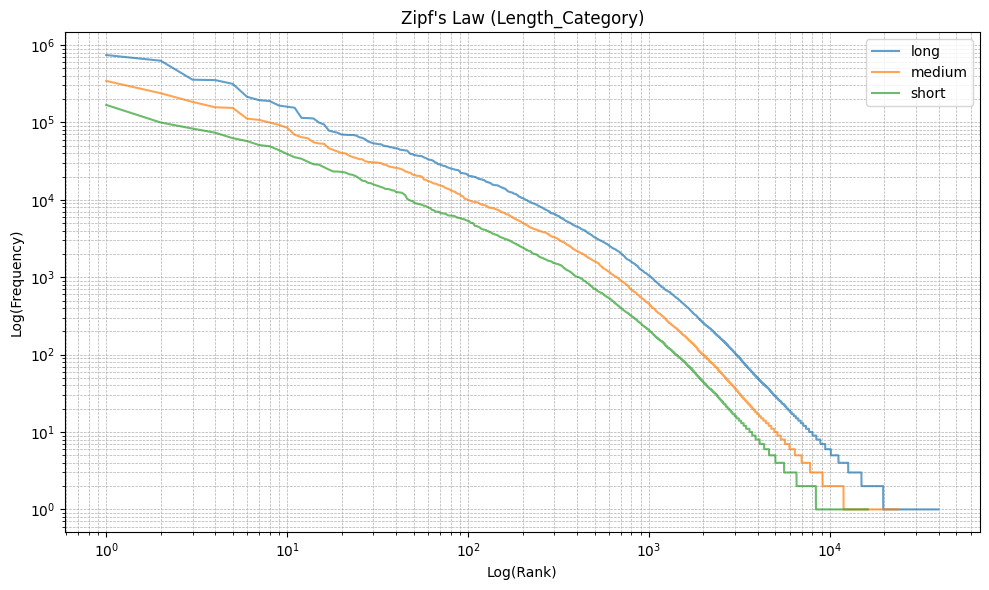


Zipf's Law Fit Results (alpha, R^2) by Length_Category


C:\Users\Kvmilos\AppData\Local\Temp\ipykernel_24668\523992455.py:2: RuntimeWarning: overflow encountered in power
  return C * rank ** (-alpha)
C:\Users\Kvmilos\AppData\Local\Temp\ipykernel_24668\523992455.py:2: RuntimeWarning: overflow encountered in multiply
  return C * rank ** (-alpha)


long                 -> alpha = 0.81, R^2 = 0.96
medium               -> alpha = 0.79, R^2 = 0.96
short                -> alpha = 0.78, R^2 = 0.96


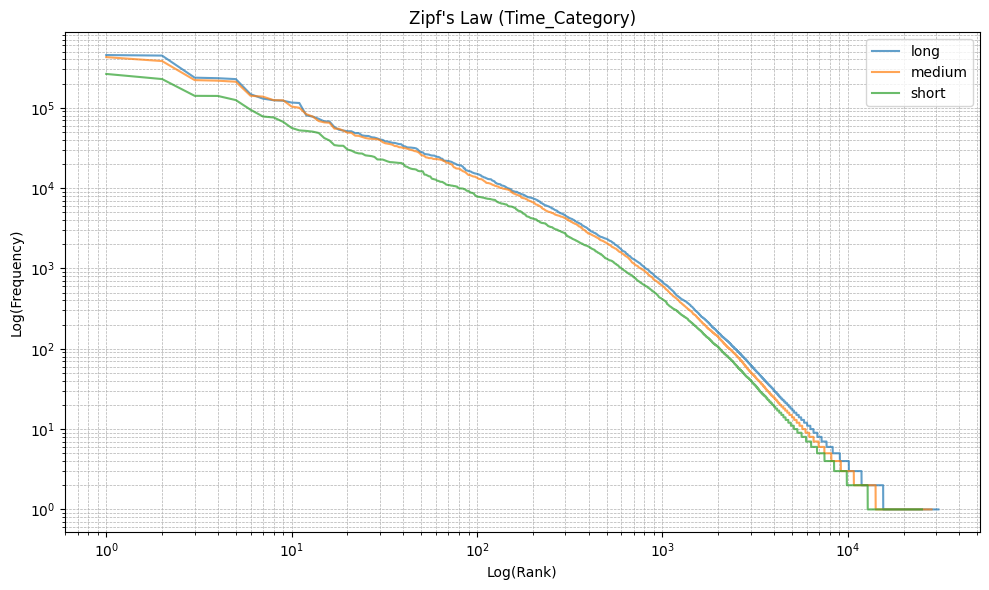


Zipf's Law Fit Results (alpha, R^2) by Time_Category


C:\Users\Kvmilos\AppData\Local\Temp\ipykernel_24668\523992455.py:2: RuntimeWarning: overflow encountered in power
  return C * rank ** (-alpha)
C:\Users\Kvmilos\AppData\Local\Temp\ipykernel_24668\523992455.py:2: RuntimeWarning: overflow encountered in multiply
  return C * rank ** (-alpha)


long                 -> alpha = 0.79, R^2 = 0.94
medium               -> alpha = 0.79, R^2 = 0.95
short                -> alpha = 0.79, R^2 = 0.95


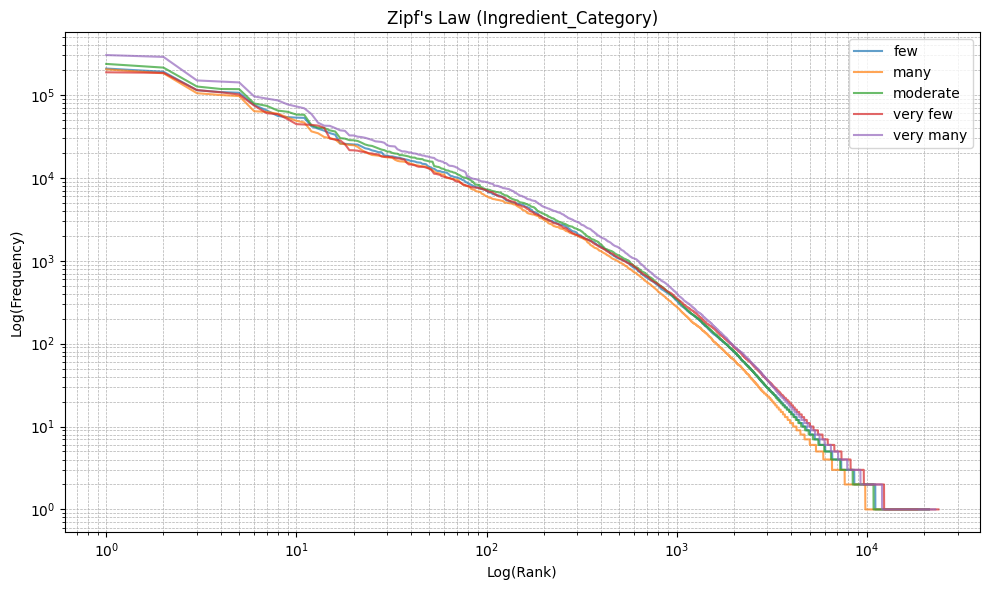


Zipf's Law Fit Results (alpha, R^2) by Ingredient_Category


C:\Users\Kvmilos\AppData\Local\Temp\ipykernel_24668\523992455.py:2: RuntimeWarning: overflow encountered in power
  return C * rank ** (-alpha)
C:\Users\Kvmilos\AppData\Local\Temp\ipykernel_24668\523992455.py:2: RuntimeWarning: overflow encountered in multiply
  return C * rank ** (-alpha)


few                  -> alpha = 0.78, R^2 = 0.95
many                 -> alpha = 0.79, R^2 = 0.95
moderate             -> alpha = 0.79, R^2 = 0.95
very few             -> alpha = 0.78, R^2 = 0.94
very many            -> alpha = 0.80, R^2 = 0.95


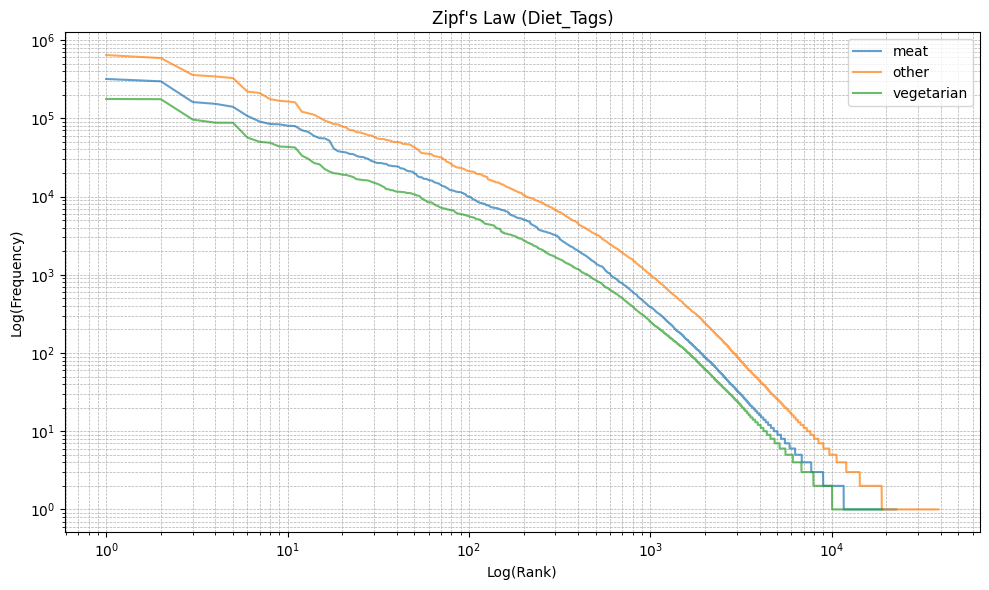


Zipf's Law Fit Results (alpha, R^2) by Diet_Tags


C:\Users\Kvmilos\AppData\Local\Temp\ipykernel_24668\523992455.py:2: RuntimeWarning: overflow encountered in power
  return C * rank ** (-alpha)
C:\Users\Kvmilos\AppData\Local\Temp\ipykernel_24668\523992455.py:2: RuntimeWarning: overflow encountered in multiply
  return C * rank ** (-alpha)


meat                 -> alpha = 0.79, R^2 = 0.95
other                -> alpha = 0.79, R^2 = 0.95
vegetarian           -> alpha = 0.80, R^2 = 0.94


In [132]:
for col in ['cuisine', 'length_category', 'time_category', 'ingredient_category', 'diet_tags']:
    zipf_analysis(recipes_filtered, col)